In [1]:
%matplotlib inline
# najczesciej dla ulatwienia robi sie import pyplot 
import matplotlib.pyplot as plt
from lightkurve import KeplerTargetPixelFile
import numpy as np
import math


``` 
* Ja zwykle robie tak że stale zostawiam w osobnej komórce, importy w osobnej itp
* zawsze spacje przed i po znaku = ```

In [2]:
bjd0 = 2454833. # stala odejmowana od czasu
kp = 6          # zczytuj dokladnie kp - pikseli liczac z najjasniejszym
b = 3           # l.pix wokol najjasniejszego piksela, czyli bok_ramki=b+1+b 
                # (2b+1)x(2b+1) pikseli. b=3 => bok 7 pikseli, ramka 49 pikseli

In [3]:
tpf = KeplerTargetPixelFile("b2_lpd.fits")
bjd = tpf.astropy_time.value

# spacje po przecinku, 
lp, xr, yc = tpf.flux.shape
# wypisz rozmiar: lp - l. zdjec CCD,  xr x yc - (wierszy x kolumny)
# rozmiar kazdego ze zdjec CCD
# print('l. zdjec, rozmiar (xr,yc):', lp, xr, yc, '\n')

# kp nie moze byc za male (bo liczmy strumien dla maks 6 pikseli min 1 piksela)
if kp < 6: kp=6
# kp nie moze byc wieksze od l. piks w ramce wokol jansego piksela      
if kp > (2*b+1)*(2*b+1): 
    kp = (2*b+1)*(2*b+1)     
if kp > xr*yc: 
    kp = xr*yc # zeby np nie przekroczylo liczby pikseli na ccd 

# od razu kilka apertur mniejszych niz kp
kp5=kp-5
    
# możesz też używać print w takim formacie, '/n' na koncu jest domyślne dla print()
print('{} zdjec, rozmiar xr:{}, yr:{}'.format(lp, xr, yc))


2422 zdjec, rozmiar xr:21, yr:22


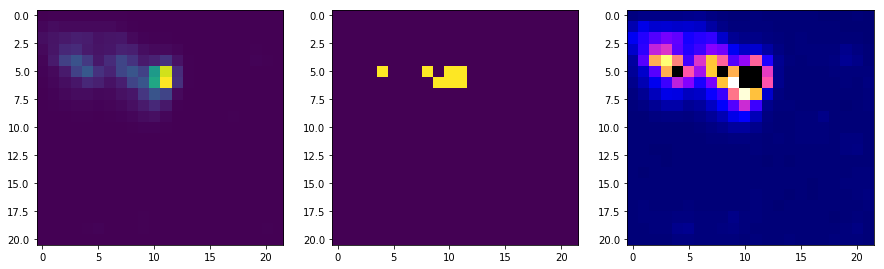

     1909.197625  41959.9  204.8   6     11472.5  107.1   1      505



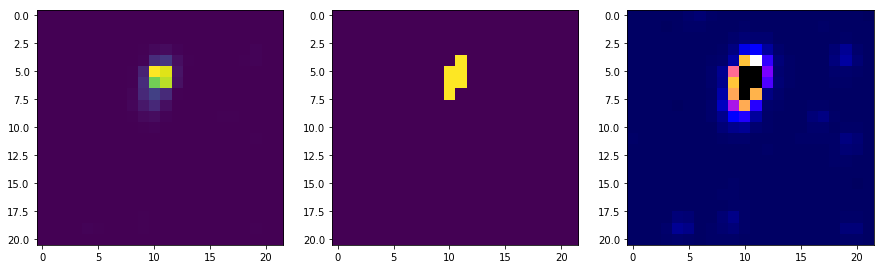

     1909.218057  90627.9  301.0   6     22598.9  150.3   1      506



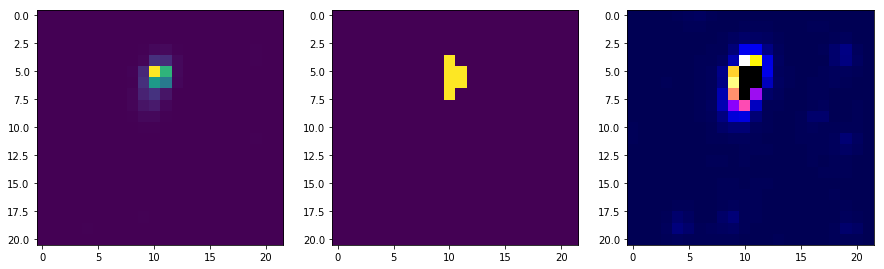

     1909.238489  89228.2  298.7   6     30519.7  174.7   1      507



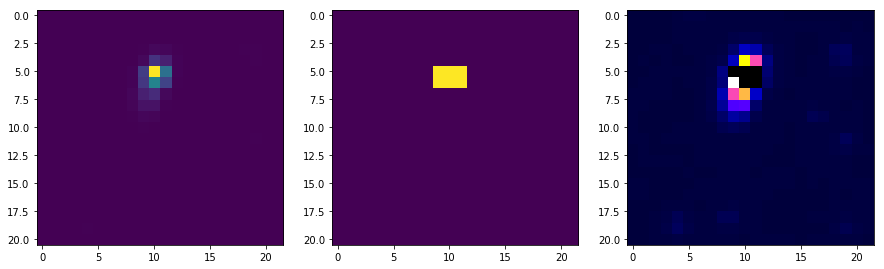

     1909.258921  88087.8  296.8   6     36828.5  191.9   1      508



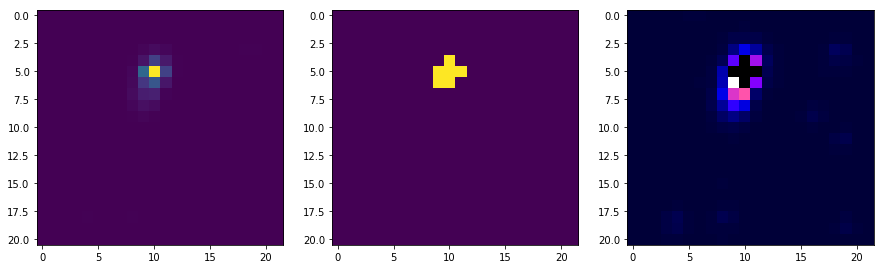

     1909.279353  90428.5  300.7   6     41720.8  204.3   1      509



In [4]:
l1=505      # od ktorego zdjecia ma pokazywac zdjecie
l2=510      # do ktorego ccd rysowac
# czy chcesz rysowac?
plot = True
# czy chcesz zapisac?
write = True
# lepiej użyć enumerate, zwraca counter (i = i + 1) oraz obiekt
# mozesz ograniczyc sie do konkretnych obrazów, np od 10 do 15 tpf.flux[10:15]
itim=l1
for i, flux_im in enumerate(tpf.flux[l1:l2]): 
    # zastap ewentualne osobliwosci zerem
    flux_im[~np.isfinite(flux_im)] = 0
    # ujemnym pikselom przypisz wartosc 0 
    flux_im[flux_im<0] = 0
    # polozenie max piksela    
    a1,a2 = np.unravel_index(flux_im.argmax(), (xr,yc))  # ponoc szybsze
    # wytnij ramka wokol najjasniejszego piksela +-b wokol niego (nie przekraczajac brzegow ccd)
    ramk = (flux_im[max(a1-b,0):min(a1+b+1,xr),max(a2-b,0):min(a2+b+1,yc)])

    # wyciagamy wszytko do jednego wymiaru
    flux = ramk.flatten()
    flux.sort()

    n = len(flux)-1  # n - indeks najjasniejszego piksela w ccdp 
    
    nb0 = n-kp+1               # nr piksela do ktorego ma sumowac, +1 bo do indeksu 0
    if nb0 < 0: nb0 =0         # minimalna wartosc wskaznika    
    nb5 = n-kp5+1              # nr piksela do ktorego ma sumowac, +1 bo do indeksu 0
    if nb5 < 0: nb5 =0         # minimalna wartosc wskaznika    
    
    # sumujemy strumien kp,kp5 pikseli         
    sump0, sump5 = 0, 0 
    k = n    
    while k >= nb0:            # sumuj np pikseli w dol jasnosci od najjasniejszego
        sump0 = sump0+flux[k]
        if k >= nb5: sump5 = sump5+flux[k]
        k = k-1
    k=k+1           

    se0 = math.sqrt(sump0)   # bledy w kolejnych aperturach (wiekszy nr, mniejsza apertura) jako sqrt(ADU)
    se5 = math.sqrt(sump5)   # blad szumu 
    
    # wizualizacja
    # czysty obraz, pixele dodatnie (zaciemnione), pixele brane do sumy (czarne)
    if plot:
        pixels_to_sum = flux_im > flux[k]

        fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15,15))
        axs[0].imshow(flux_im)
        axs[1].imshow(flux_im>=flux[nb0])
#        axs[1].imshow(flux_im > flux[k], cmap='binary', alpha=0.5)

        mask = flux_im.copy()
        mask[pixels_to_sum] = -99
        axs[2].imshow(mask, cmap='gnuplot2')
        plt.show()
        # tutaj dobrze by bylo poszalec z cmap
        
    # wypisz BJD-bjd0, flux, flux_err, l.pix, flux_z_calej_ramki, err_ramki,
    # l.piks w ramce, zdjecia
    print("{:16.6f}  {:7.1f} {:6.1f} {:3d}     {:7.1f} {:6.1f} {:3d}  {:7d}\n".format(
       bjd[itim]-bjd0, sump0,se0,kp, sump5,se5,kp5, itim))
    itim=itim+1
  